In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

from transformers import BertTokenizer, TFBertForSequenceClassification

from sklearn.model_selection import train_test_split

C:\Users\anton\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [18]:
df = pd.read_csv('df-for-bert-with-UD-final.csv')
df = df.drop('Unnamed: 0', 1)
df

C:\Users\anton\AppData\Local\Temp/ipykernel_19892/3805410947.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('Unnamed: 0', 1)


,n,Labels,comment_text
0,16.0,0,rapporterade avpixlat om för någon timme sedan...
1,24.0,0,hemskt det som hänt undra om det kommer en an...
2,55.0,0,det finns redan visst skydd på gatan bl a be...
3,34.0,0,det är helt omöjligt att köra med lastbil på d...
4,21.0,1,jimmie åkesson hade en längre utläggning i svt...
...,...,...,...
9680,59.0,2,frågan om det var planerat eller stundens ingi...
9681,NaN,2,samt ljuger de för allmänheten svensk polis i ...
9682,NaN,2,ok experten jag demolerar nu också mitt fantas...
9683,NaN,2,han ska inte vara med här punkt


In [20]:
df_for_eval = pd.read_csv('df-for-eval-with-UD-final.csv')
df_for_eval = df_for_eval.drop('Unnamed: 0', 1)
df_for_eval

C:\Users\anton\AppData\Local\Temp/ipykernel_19892/525790782.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_for_eval = df_for_eval.drop('Unnamed: 0', 1)


,n,Labels,comment_text
0,11,0,här ses lastbilen susa förbi filmat från överv...
1,35,0,spendrups berättar att chauffören börjat lasta...
2,9,0,finns lite bilder på offer i kommentarerna fy...
3,44,0,angående videoklippet på folk som flyr tit...
4,10,0,fast det gör ju inte du heller i ditt inlägg
...,...,...,...
535,5,0,bild på den efterlyste mannen
536,45,0,man gör en på riktigt personen tror alltså a...
537,30,0,nyss spärrade man av e an norrut vid påfartern...
538,5,0,blir ahmedov med våra bokstäver


In [21]:
seq_len = 512
num_samples = len(df)

num_samples, seq_len

(9685, 512)

In [18]:
tokenizer = BertTokenizer.from_pretrained('KB/bert-base-swedish-cased')

In [ ]:
tokens = tokenizer(df['comment_text'].tolist(), max_length=seq_len, truncation=True,
                   padding='max_length', add_special_tokens=True,
                   return_tensors='np')

In [23]:
with open('toxic2-xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])
with open('toxic2-xmask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])

In [24]:
del tokens

In [25]:
arr = df['Labels'].values

In [26]:
labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(9685, 3)

In [27]:
labels[np.arange(num_samples), arr] = 1

labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [28]:
with open('toxic2-labels.npy', 'wb') as f:
    np.save(f, labels)

In [29]:
with open('toxic2-xids.npy', 'rb') as f:
    Xids = np.load(f, allow_pickle=True)
with open('toxic2-xmask.npy', 'rb') as f:
    Xmask = np.load(f, allow_pickle=True)
with open('toxic2-labels.npy', 'rb') as f:
    labels = np.load(f, allow_pickle=True)

In [30]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(3,), dtype=tf.float64, name=None))>

In [31]:
def map_func(input_ids, masks, labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# then we use the dataset map method to apply this transformation
dataset = dataset.map(map_func)

dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int32, name=None)}, TensorSpec(shape=(3,), dtype=tf.float64, name=None))>

In [32]:
batch_size = 3

dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(3, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(3, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(3, 3), dtype=tf.float64, name=None))>

In [33]:
split = 0.9

# we need to calculate how many batches must be taken to create 90% training set
size = int((Xids.shape[0] / batch_size) * split)

size

2905

In [34]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

# free up memory
del dataset

In [35]:
tf.data.experimental.save(train_ds, 'train2')
tf.data.experimental.save(val_ds, 'val2')

In [36]:
train_ds.element_spec

({'input_ids': TensorSpec(shape=(3, 512), dtype=tf.int32, name=None),
  'attention_mask': TensorSpec(shape=(3, 512), dtype=tf.int32, name=None)},
 TensorSpec(shape=(3, 3), dtype=tf.float64, name=None))

In [37]:
val_ds.element_spec == train_ds.element_spec

True

In [38]:
ds = tf.data.experimental.load('train2', element_spec=train_ds.element_spec)

In [39]:
bert = TFBertForSequenceClassification.from_pretrained('KB/bert-base-swedish-cased')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at KB/bert-base-swedish-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

In [41]:
input_ids

<KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'input_ids')>

In [42]:
embeddings = bert.bert(input_ids, attention_mask=mask)[1]

In [43]:
x = tf.keras.layers.Dense(256, activation='relu')(embeddings)
y = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(x)

In [44]:
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

In [45]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  124690944   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [46]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')
prec = tf.keras.metrics.Precision()
reca = tf.keras.metrics.Recall()
f1_ = tfa.metrics.F1Score(num_classes=3,
                        average='macro',
                        threshold=0.5)

model.compile(optimizer=optimizer, loss=loss, metrics=[acc, prec, reca, f1_])

In [47]:
element_spec = ({'input_ids': tf.TensorSpec(shape=(3, 512), dtype='int32', name=None),
                 'attention_mask': tf.TensorSpec(shape=(3, 512), dtype='int32', name=None)},
                tf.TensorSpec(shape=(3, 3), dtype=tf.float64, name=None))

In [48]:
train_ds = tf.data.experimental.load('train2', element_spec=element_spec)
val_ds = tf.data.experimental.load('val2', element_spec=element_spec)

In [49]:
train_ds.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(3, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(3, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(3, 3), dtype=tf.float64, name=None))>

In [50]:
history_ = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1
)

2905/2905 [==============================] - 31090s 11s/step - loss: 0.5411 - accuracy: 0.7852 - precision: 0.8263 - recall: 0.7343 - f1_score: 0.7285 - val_loss: 0.1613 - val_accuracy: 0.9474 - val_precision: 0.9521 - val_recall: 0.9432 - val_f1_score: 0.9467


In [51]:
model.save('toxic-bert-2')

INFO:tensorflow:Assets written to: toxic-bert-2\assets


INFO:tensorflow:Assets written to: toxic-bert-2\assets


In [3]:
trained_model_Bert = tf.keras.models.load_model('toxic-bert-2')

In [4]:
def prep_data(text):
    tokens = tokenizer.encode_plus(text, max_length=512,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    
    return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}

In [54]:
df_for_eval['Pred_Labs'] = None

In [55]:
df_for_eval

,n,Labels,comment_text,Pred_Labs
0,11,0,här ses lastbilen susa förbi filmat från överv...,None
1,35,0,spendrups berättar att chauffören börjat lasta...,None
2,9,0,finns lite bilder på offer i kommentarerna fy...,None
3,44,0,angående videoklippet på folk som flyr tit...,None
4,10,0,fast det gör ju inte du heller i ditt inlägg,None
...,...,...,...,...
535,5,0,bild på den efterlyste mannen,None
536,45,0,man gör en på riktigt personen tror alltså a...,None
537,30,0,nyss spärrade man av e an norrut vid påfartern...,None
538,5,0,blir ahmedov med våra bokstäver,None


In [56]:
for i, row in df_for_eval.iterrows():
    # get token tensors
    tokens = prep_data(row['comment_text'])
    # get probabilities
    probs = trained_model_Bert.predict(tokens)
    # find argmax for winning class
    pred = np.argmax(probs)
    # add to dataframe
    df_for_eval.at[i, 'Pred_Labs'] = pred

df_for_eval.head()

,n,Labels,comment_text,Pred_Labs
0,11,0,här ses lastbilen susa förbi filmat från överv...,0
1,35,0,spendrups berättar att chauffören börjat lasta...,0
2,9,0,finns lite bilder på offer i kommentarerna fy...,0
3,44,0,angående videoklippet på folk som flyr tit...,0
4,10,0,fast det gör ju inte du heller i ditt inlägg,0


In [57]:
df_for_eval['Pred_Labs'].unique()

array([0, 1, 2], dtype=object)

In [58]:
df_for_eval['Labels'].unique()

array([0, 1, 2], dtype=int64)

In [59]:
df_for_eval['Labels'] = df_for_eval['Labels'].astype(str)

In [60]:
df_for_eval['Pred_Labs'] = df_for_eval['Pred_Labs'].astype(str)

In [61]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
y_true = df_for_eval['Labels']
y_pred = df_for_eval['Pred_Labs']
labels = [0,1,2]

In [62]:
cfm = confusion_matrix(y_true, y_pred)

In [63]:
f1_scores = f1_score(y_true, y_pred, average=None, labels=labels)
f1_scores_with_labels = {label:score for label,score in zip(labels, f1_scores)}

C:\Users\anton\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:579: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  >>> mask = np.in1d(test, states, invert=True)


In [64]:
f1_scores
f1_scores_with_labels

{0: 0.9875424688561723, 1: 0.9459459459459458, 2: 0.8979591836734693}

In [65]:
import seaborn as sn
import matplotlib.pyplot as plt

<AxesSubplot:>

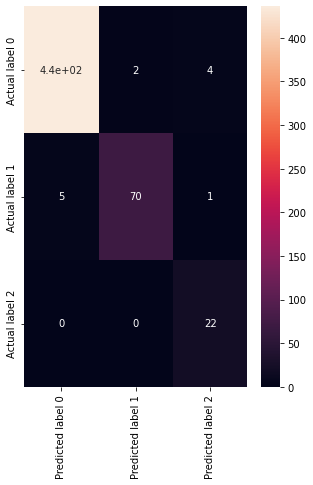

In [66]:
x_axis_labels = ['Predicted label 0','Predicted label 1','Predicted label 2']
y_axis_labels = ['Actual label 0','Actual label 1','Actual label 2'] 
fig = plt.figure(figsize=(17,7))
plt.subplot(1,3,1)
sn.heatmap(cfm, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True)

In [68]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [72]:
y_true = df_for_eval['Labels']
y_pred = df_for_eval['Pred_Labs']
labels = [0,1,2]

In [73]:
accuracy_score(y_true, y_pred)

0.9777777777777777

In [74]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       442
           1       0.97      0.92      0.95        76
           2       0.81      1.00      0.90        22

    accuracy                           0.98       540
   macro avg       0.93      0.97      0.94       540
weighted avg       0.98      0.98      0.98       540



In [75]:
clf_report = classification_report(y_true,
                                   y_pred,
                                   labels=labels,
                                   target_names=labels,
                                   output_dict=True)

C:\Users\anton\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:579: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  >>> mask = np.in1d(test, states, invert=True)
C:\Users\anton\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:579: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  >>> mask = np.in1d(test, states, invert=True)
C:\Users\anton\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:579: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  >>> mask = np.in1d(test, states, invert=True)
C:\Users\anton\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:579: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  >>> mask = np.in1d(test, states, invert=True)


In [76]:
import seaborn as sn

<AxesSubplot:>

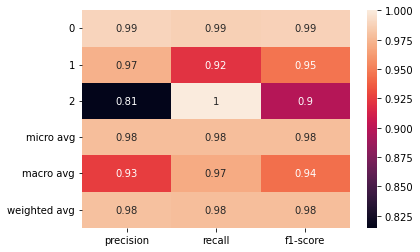

In [77]:
sn.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

In [4]:
df_pr = pd.read_csv("Annotation-data-test.csv")

In [5]:
df_pr = df_pr.drop('Unnamed: 0', 1)

C:\Users\anton\AppData\Local\Temp/ipykernel_15708/3171545454.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_pr = df_pr.drop('Unnamed: 0', 1)


In [7]:
df_pr = df_pr[df_pr['lab_toxic'].isna()]

In [8]:
df_pr = df_pr.drop(['lab_toxic', 'lab_undetermined', 'lab_not_toxic'], axis = 1)

In [9]:
df_pr['comment_text'] = df_pr['comment.text']

In [10]:
df_pr = df_pr.drop(['comment.text'], axis = 1)

In [17]:
df_pr['Labels'] = None

for i, row in df_pr.iterrows():
    # get token tensors
    tokens = prep_data(row['comment_text'])
    # get probabilities
    probs = trained_model_Bert.predict(tokens)
    # find argmax for winning class
    pred = np.argmax(probs)
    # add to dataframe
    df_pr.at[i, 'Labels'] = pred

df_pr.head()

,id,post.nr,date,n,phaseType,Machine_Translation,toxicity,severe_toxicity,comment_text,Labels
5400,1959,5444,4/8/2017,49,A,Maybe it was a vain attempt to protect his rel...,0.004237533,0.000004,kanske var ett fåfängt försök att skydda sina ...,0
5401,2481,5445,4/8/2017,6,A,recently received phone calls that gunfire occ...,0.00058239576,0.000002,fick nyligen telefonsamtal att skottlossning f...,0
5402,1184,5446,4/8/2017,29,A,the strike in the springberg someone who knows...,0.00068851287,0.000001,tillslaget i vårberg någon som vet adress och...,0
5403,921,5447,4/8/2017,10,A,is it confirmed that there was an explosive ch...,0.00064745656,0.000002,är det bekräftat att det var en sprängladdning...,0
5404,848,5448,4/8/2017,29,A,saw now fyfan hope gm encounters a times worse...,0.07736898,0.000025,såg nu fyfan hoppas gm råkar ut för en ggr ...,0


In [18]:
df_pr['Labels'].value_counts()

0    8445
1     580
2     172
Name: Labels, dtype: int64

In [19]:
df_pr.to_csv('df_pr.csv', index = True, encoding = 'utf-8-sig')

In [33]:
df_ = pd.read_csv("Annotation-data-test.csv")

In [21]:
df_ = df_.drop('Unnamed: 0', 1)

C:\Users\anton\AppData\Local\Temp/ipykernel_15708/3488948141.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_ = df_.drop('Unnamed: 0', 1)


In [22]:
cols = df_.iloc[:, 9:12]

In [23]:
def get_labels(row):
    for col in cols:
        if row[col] == 1:
            return col

df_['Labels'] = df_.apply(get_labels, axis=1)

In [24]:
df_['comment_text'] = df_['comment.text']

In [25]:
df_ = df_.drop(['comment.text','lab_toxic', 'lab_undetermined', 'lab_not_toxic'], axis = 1)

In [26]:
df_ = df_.dropna()

In [27]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_['Labels'] = le.fit_transform(df_['Labels'])

In [28]:
df_ = df_.reindex(columns=['id','post.nr','date','n','phaseType','Labels','comment_text','Machine_Translation', 'toxicity', 'severe_toxicity'])

In [29]:
df_pr = df_pr.reindex(columns=['id','post.nr','date','n','phaseType','Labels','comment_text','Machine_Translation', 'toxicity', 'severe_toxicity'])

In [30]:
bigdata = df_.append(df_pr, ignore_index=True)

C:\Users\anton\AppData\Local\Temp/ipykernel_15708/3863484548.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bigdata = df_.append(df_pr, ignore_index=True)


In [31]:
bigdata

,id,post.nr,date,n,phaseType,Labels,comment_text,Machine_Translation,toxicity,severe_toxicity
0,2320,1,4/7/2017,51,A,0,fick just samtal att en lastbil kört över mass...,just got the call that a truck drove over a lo...,0.00047108432,0.000001
1,2369,2,4/7/2017,116,A,0,andra trådar kopplade till terrorattentatet på...,other threads linked to the terrorist attack o...,0.016395519,0.000048
2,1444,3,4/7/2017,15,A,0,har även jag hört från en på plats nya spänna...,I have also heard from an on-site new exciting...,0.00052031956,0.000001
3,2428,4,4/7/2017,17,A,0,enligt nyhetsflash från aftonbladet har en las...,According to news flash from the evening paper...,0.00070197333,0.000001
4,2470,5,4/7/2017,1,A,0,terrorattack,terrorist attack,0.052802633,0.000011
...,...,...,...,...,...,...,...,...,...,...
14587,137,14709,12/23/2021,11,C,0,muhammad mördade både kvinnor barn och äldre ...,Muhammad murdered both women children and olde...,0.098266706,0.000064
14588,1123,14710,12/24/2021,261,C,0,tack för ditt intressanta inlägg det är rel...,Thanks for your interesting post it is relativ...,0.5762896,0.002090
14589,39,14711,12/24/2021,23,C,0,problemet är att sverige har ingen skarprättar...,The problem is that Sweden has no executioner ...,0.07746462,0.000018
14590,1884,14712,12/25/2021,60,C,1,även en blind höna hittar ett korn dvs det är...,even a blind hen finds a grain i.e. it's posit...,0.0024845921,0.000003


In [32]:
bigdata.to_csv('bigdata-W-UD.csv', index = True, encoding = 'utf-8-sig')

In [185]:
column = bigdata["id"]
max_value = column.max()

In [186]:
max_value

2656